In [5]:
import tensorflow as tf
import keras

import os

from keras.utils import image_dataset_from_directory, load_img, img_to_array
from keras.optimizers import Adam

from keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#today
#TODO streamline functions

#tmr
#TODO improve model overfitting (lower drop out)



## Load data from Directory

In [24]:

img_shape = (48,48) #shape of image
BS = 16 #batch size per iteration of sequence
dir_train_images = 'data/Training'
dir_test_images = 'data/Test'

train_ds = image_dataset_from_directory(
    dir_train_images,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=img_shape,
    batch_size=BS,
    color_mode = 'grayscale',
    labels = 'inferred'
)

val_ds = image_dataset_from_directory(
    dir_train_images,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=img_shape,
    batch_size=BS,
    color_mode = 'grayscale',
    labels = 'inferred'

)

test_ds = image_dataset_from_directory(
    dir_test_images,
    seed=1337,
    image_size=img_shape,
    batch_size=BS,
    color_mode = 'grayscale',
    labels = 'inferred'
)

class_names = train_ds.class_names #list of class labels 
num_cat = len(class_names) #number of classes

Found 27463 files belonging to 7 classes.
Using 21971 files for training.
Found 27463 files belonging to 7 classes.
Using 5492 files for validation.
Found 6584 files belonging to 7 classes.


In [25]:
class_names

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

## Augment dataset

Increase the diversity of training set by applying random transformations to images. 
In this images were randomly horizontally flipped, rotated, and zoomed in.

In [7]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=img_shape+(1,)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

### showcase data augmentation with example image

In [8]:
def showcase_augmented_image(dataset, aug_sequence):
    plt.figure(figsize=(8, 8), facecolor='black')
    plt.suptitle("Example of an image augmented", fontsize=14, color = 'white')
    for image, _ in dataset.take(1):
        for i in range(9):
            augmented_images = aug_sequence(image)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

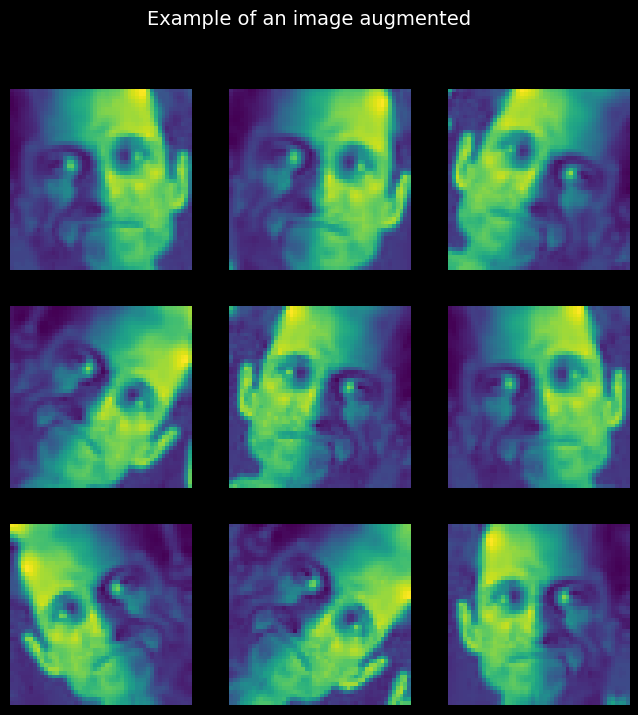

In [9]:
showcase_augmented_image(train_ds, data_augmentation)

## The Sequential model design

In [11]:

shallow_sequence = [
    #preproccesing data
    data_augmentation,
    
    #Standardize the data
    layers.Rescaling(1./255), #convert pixel data to floats (between 0 and 1)
    
    #layer 1
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"), #stride size = 1
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    #layer 2
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), #stride size = 1
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    #FC layer
    layers.Flatten(),
    layers.Dense(512, activation='relu'),

    #logistic layer
    layers.Dense(num_cat, activation='softmax')

  ]

## Compile the model

In [44]:
def facial_expr_model(sequence):
    
    model = keras.Sequential(sequence)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model

In [45]:
model = facial_expr_model(shallow_sequence)
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_27 (Sequential)  (None, 48, 48, 1)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 48, 48, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 46, 46, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 64)        18496     
                                                     

## Fit model to the training data

In [46]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1
)

1374/1374 [==============================] - 546s 396ms/step - loss: 3.0255 - accuracy: 0.2714 - val_loss: 1.9417 - val_accuracy: 0.3003


## Evaluate model.
In addition, a plot of the loss and accuracy on the training and validation sets.

In [38]:
def eval_model_stats(history):
    # Evaluate the model
    loss, acc = model.evaluate(test_ds, verbose=2)
    print("Accuracy: {:5.2f}%".format(100 * acc))

In [39]:
def plot_model_peformance(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
eval_model_stats(history)
plot_model_peformance(history, epochs)

## Save model

In [49]:
def save_model_weights(model, model_id):
    model.save(f'my_model_{model_id}', save_format='h5')

In [50]:
save_model_weights(model, 1)

### demonstrate loading the model

In [6]:
from keras.models import load_model
loaded_model = load_model('my_model_1')

## predict image label

In [11]:
def predict_image(image_path, model):

    img = load_img(
        image_path, target_size=img_shape, color_mode = 'grayscale'
        )

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    return(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [12]:
predict_image('data/Test/Happy/img_28728.jpeg', loaded_model)

1/1 [==============================] - 0s 272ms/step


'This image most likely belongs to Happy with a 23.15 percent confidence.'

In [13]:
image_path = 'assets/trial_run_1.jpg'


img = load_img(image_path, target_size=img_shape, color_mode = 'grayscale')

img_array = img_to_array(img)
img_array = np.expand_dims(img_array, 0) # Create a batch

predictions = loaded_model.predict(img_array)

1/1 [==============================] - 0s 66ms/step


In [23]:
%%writefile functions/showcase_prediction.py
def showcase_prediction(predictions_array, class_label, img_path):
    
    
    score_value = tf.nn.softmax(predictions_array[0])
    max_index = np.argmax(score_value)
    true_label = class_label[max_index]
    
    
    
    plt.figure(figsize=(8, 4))
    plt.subplots_adjust(wspace=0.1)
    plt.subplots_adjust(bottom = 0.18)
    # plt.suptitle(f"Predicted Emotion: {true_label} ({np.round(predictions_array[0,max_index]*100,2)}%)", fontsize=14, color = 'black')
    
    plt.suptitle(f"Predicted Emotion: {true_label} ({np.round(np.max(score_value)*100,2)}%)", fontsize=14, color = 'black')

    
    #plot predicting certainty
    ax1 = plt.subplot(1,2,1)
    showcase_prediction = ax1.bar(class_label, (score_value*100), color="#A7C7E7")
    showcase_prediction[max_index].set_color('#1F51FF')
    plt.xticks(rotation = 45)
    plt.ylabel("Certainty (%)")
    
    
    #plot image
    ax2 = plt.subplot(1,2,2)
    img = load_img(image_path, target_size=img_shape, color_mode = 'grayscale')
    img_array = img_to_array(img)
    ax2.imshow(img_array)
    ax2.axis('off')
    
    plt.savefig('assets/predicted_'+(os.path.basename(img_path)))
    
    plt.show()
    

Writing functions/showcase_prediction.py


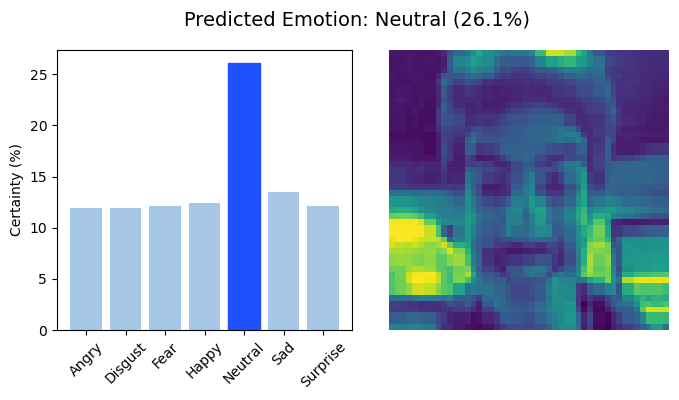

In [22]:
##potential error with softmax
showcase_prediction(predictions, class_names, image_path) 

In [16]:
('predicted_'+(os.path.basename(image_path)))

'predicted_trial_run_1.jpg'

In [285]:
#difference betweem

'''
 score_value = tf.nn.softmax(predictions_array[0])
 
AND

 max_percentage = np.max(score_value)
 
'''

'\n score_value = tf.nn.softmax(predictions_array[0])\n \nAND\n\n max_percentage = np.max(score_value)\n \n'